In [1]:
# PACKAGE: DO NOT EDIT
import numpy as np
import timeit

In [2]:
# PACKAGE: DO NOT EDIT
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from ipywidgets import interact

from sklearn.datasets import fetch_mldata
MNIST = fetch_mldata('MNIST original', data_home='./MNIST')
%matplotlib inline

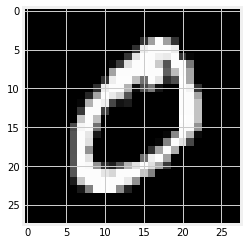

In [3]:
plt.figure(figsize=(4,4))
plt.imshow(MNIST.data[0].reshape(28,28), cmap='gray');

In [4]:
MNIST.data = np.clip(MNIST.data.astype(float),0,1)

In [5]:
# GRADED FUNCTION: DO NOT EDIT

def normalize(X):
    """Normalize the given dataset X
    Args:
        X: ndarray, dataset
    
    Returns:
        (Xbar, mean, std): ndarray, Xbar is the normalized dataset
        with mean 0 and standard deviation 1; mean and std are the 
        mean and standard deviation respectively.
    
    Note:
        You will encounter dimensions where the standard deviation is
        zero, for those when you do normalization the normalized data
        will be NaN. Handle this by setting using `std = 1` for those 
        dimensions when doing normalization.
    """
    
    D,N = X.shape     
    mu = np.mean(X,axis=0)      #mean by column, the mean should be a row(one image)(variable centree)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = np.subtract(X,mu) / std_filled   
    return (Xbar,mu,std)

def eig(S):
    """Compute the eigenvalues and corresponding eigenvectors 
        for the covariance matrix S.
    Args:
        S: ndarray, covariance matrix
    
    Returns:
        (eigvals, eigvecs): ndarray, the eigenvalues and eigenvectors

    Note:
        the eigenvals and eigenvecs should be sorted in descending
        order of the eigen values
    """
    (eigvals, eigvecs) = np.linalg.eigh(S)
    return (eigvals, eigvecs) 

def projection_matrix(B):
    """Compute the projection matrix onto the space spanned by `B`
    Args:
        B: ndarray of dimension (D, M), the basis for the subspace
    
    Returns:
        P: the projection matrix
    """ 
    P = B @ np.linalg.inv(np.transpose(B) @ B) @ np.transpose(B)
    return P

def PCA(X, num_components):    
    """
    Args:
        X: ndarray of size (N, D), where D is the dimension of the data,
           and N is the number of datapoints
        num_components: the number of principal components to use.
    Returns:
        X_reconstruct: a tuple where the first item is the reconstruction
        of X from the first `num_components` principal components.
    """
    Xbar,mu,std = normalize(X)     # Step 1 to 3: normalization
    
    S = np.cov(Xbar, rowvar=False, bias = True)  # compute the covariance matrix
    N,D = Xbar.shape
    
    eigen = eig(S)                 # Step 4: compute the eigenpair
    values = eigen[0]
    vectors =  eigen[1]   
    index = values.argsort()[::-1]  # reverse the list of eigen values after sorting
    val = values[index]
    vect = vectors[:,index]
    
    B = vect[:,0:num_components]  #Step 5-6: choose the eigenvectors associated to the num_components eigenvalues and collect them in a matrix    
    P = B @ B.T                      #Step 7: Orthogonal projection of the data onto the principal axis using the projection matrix BB.T
    proj = P @ X.T   
    X_reconstruct = proj.T              #X_reconstruct: a tuple where the first item is the reconstruction
                                     #of X from the first `num_components` principal components.

    return X_reconstruct

In [6]:
NUM_DATAPOINTS = 1000
X = (MNIST.data.reshape(-1, 28 * 28)[:NUM_DATAPOINTS]) / 255.
Xbar, mu, std = normalize(X)

In [7]:
for num_component in range(1, 20):
    from sklearn.decomposition import PCA as SKPCA
    # We can compute a standard solution given by scikit-learn's implementation of PCA
    pca = SKPCA(n_components=num_component, svd_solver='full')
    sklearn_reconst = pca.inverse_transform(pca.fit_transform(Xbar))
    reconst = PCA(Xbar, num_component)
    np.testing.assert_almost_equal(reconst, sklearn_reconst)
    print(np.square(reconst - sklearn_reconst).sum())

1.40893415002e-23
1.60509755246e-23
1.64756786395e-23
9.21188474378e-23
1.56479969242e-23
2.54289216518e-23
3.50300889685e-23
3.16497235139e-23
1.5291329722e-22
2.16874668548e-22
8.07643002226e-23
4.47507390202e-23
3.78113794198e-23
3.90539871853e-23
3.43810239588e-23
2.31160252164e-21
3.86617635361e-23
5.45217111572e-23
4.07592926222e-23


In [8]:
def mse(predict, actual):
    return np.square(predict - actual).sum(axis=1).mean()

In [9]:
loss = []
reconstructions = []
for num_component in range(1, 100):
    reconst = PCA(Xbar, num_component)
    error = mse(reconst, Xbar)
    reconstructions.append(reconst)
    # print('n = {:d}, reconstruction_error = {:f}'.format(num_component, error))
    loss.append((num_component, error))

reconstructions = np.asarray(reconstructions)
reconstructions = reconstructions * std + mu # "unnormalize" the reconstructed image
loss = np.asarray(loss)

In [10]:
import pandas as pd
pd.DataFrame(loss).head()

,0,1
0,1.0,446.450370
1,2.0,406.718529
2,3.0,382.780948
3,4.0,364.629616
4,5.0,347.210710


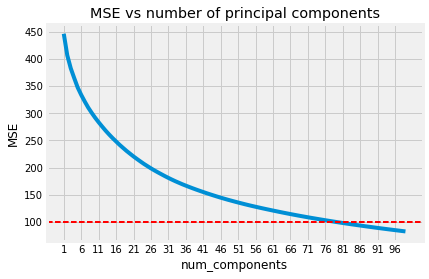

In [11]:
fig, ax = plt.subplots()
ax.plot(loss[:,0], loss[:,1]);
ax.axhline(100, linestyle='--', color='r', linewidth=2)
ax.xaxis.set_ticks(np.arange(1, 100, 5));
ax.set(xlabel='num_components', ylabel='MSE', title='MSE vs number of principal components');

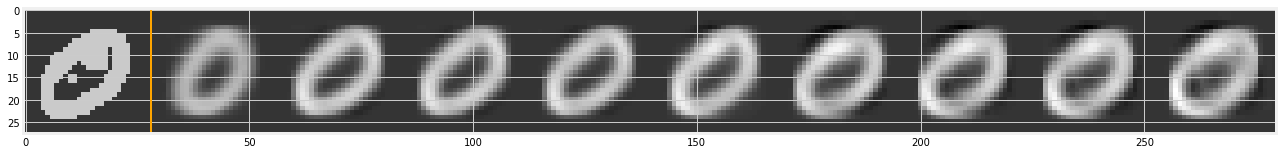

In [12]:
@interact(image_idx=(0, 999))
def show_num_components_reconst(image_idx):
    fig, ax = plt.subplots(figsize=(20., 20.))
    actual = X[image_idx]
    x = np.concatenate([actual[np.newaxis, :], reconstructions[:, image_idx]])
    ax.imshow(np.hstack(x.reshape(-1, 28, 28)[np.arange(10)]),
              cmap='gray');
    ax.axvline(28, color='orange', linewidth=2)

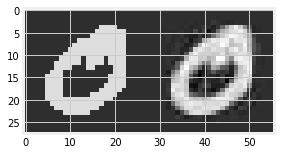

In [13]:
@interact(i=(0, 10))
def show_pca_digits(i=1):
    plt.figure(figsize=(4,4))
    actual_sample = X[i].reshape(28,28)
    reconst_sample = (reconst[i, :] * std + mu).reshape(28, 28)
    plt.imshow(np.hstack([actual_sample, reconst_sample]), cmap='gray')
    plt.show()

In [16]:
from sklearn import preprocessing

In [17]:
# GRADED FUNCTION: DO NOT EDIT
### PCA for high dimensional datasets

def PCA_high_dim(X, n_components):
    """Compute PCA for small sample size but high-dimensional features. 
    Args:
        X: ndarray of size (N, D), where D is the dimension of the sample,
           and N is the number of samples
        num_components: the number of principal components to use.
    Returns:
        X_reconstruct: (N, D) ndarray. the reconstruction
        of X from the first `num_components` pricipal components.
    """
    XXt = X @ X.T   # Step 1    
    (eigvalues, V) = np.linalg.eigh(XXt) # Step 2
    eigvecCovMatrix = X.T @ V            #Step 3: eigenvectors for the original cov matrix as X.T@V
    index = eigvalues.argsort()[::-1]        #We sort the eigenvalues from the highest to the lowest 
    eigvecCovMatrix = eigvecCovMatrix[:,index] #we sort the eigenvectors for the original cov matrix over the same order 
    B = np.array(eigvecCovMatrix[:,0:n_components])# choose the num_components largest eigen vectors to be the basis of the principal subspace U
    B = preprocessing.normalize(B, axis = 0, norm = "l2") 
 
    P = projection_matrix(B)    #Step 4: compute the projection matrix
    proj = P @ X.T              # orthogonal projection onto U
    X_reconstruct = proj.T      #(N, D) ndarray. the reconstruction of X from the first `num_components` pricipal components   
    return X_reconstruct

In [18]:
np.testing.assert_almost_equal(PCA(Xbar, 2), PCA_high_dim(Xbar, 2))

In [19]:
def time(f, repeat=100):
    times = []
    for _ in range(repeat):
        start = timeit.default_timer()
        f()
        stop = timeit.default_timer()
        times.append(stop-start)
    return np.mean(times), np.std(times)

In [20]:
times_mm0 = []
times_mm1 = []

for datasetsize in np.arange(4, 784, step=20):
    XX = Xbar[:datasetsize]
    mu, sigma = time(lambda : XX.T @ XX)
    times_mm0.append((datasetsize, mu, sigma))
    
    mu, sigma = time(lambda : XX @ XX.T)
    times_mm1.append((datasetsize, mu, sigma))
    
times_mm0 = np.asarray(times_mm0)
times_mm1 = np.asarray(times_mm1)

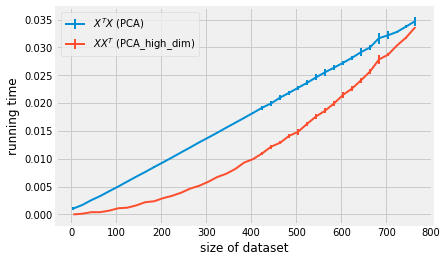

In [21]:
fig, ax = plt.subplots()
ax.set(xlabel='size of dataset', ylabel='running time')
bar = ax.errorbar(times_mm0[:, 0], times_mm0[:, 1], times_mm0[:, 2], label="$X^T X$ (PCA)", linewidth=2)
ax.errorbar(times_mm1[:, 0], times_mm1[:, 1], times_mm1[:, 2], label="$X X^T$ (PCA_high_dim)", linewidth=2)
ax.legend();

In [22]:
times0 = []
times1 = []

for datasetsize in np.arange(4, 784, step=100):
    XX = Xbar[:datasetsize]
    npc = 2
    mu, sigma = time(lambda : PCA(XX, npc), repeat=10)
    times0.append((datasetsize, mu, sigma))
    
    mu, sigma = time(lambda : PCA_high_dim(XX, npc), repeat=10)
    times1.append((datasetsize, mu, sigma))
    
times0 = np.asarray(times0)
times1 = np.asarray(times1)

In [23]:
%time Xbar.T @ Xbar
%time Xbar @ Xbar.T
pass # Put this here so that our output does not show result of computing `Xbar @ Xbar.T`

CPU times: user 50.3 ms, sys: 4 µs, total: 50.3 ms
Wall time: 49.1 ms
CPU times: user 61.1 ms, sys: 2 µs, total: 61.1 ms
Wall time: 60.8 ms


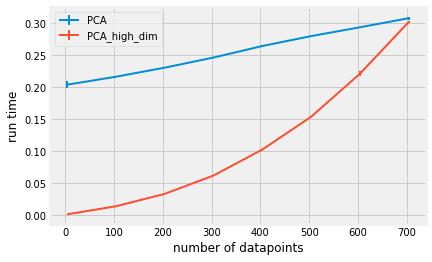

In [24]:
fig, ax = plt.subplots()
ax.set(xlabel='number of datapoints', ylabel='run time')
ax.errorbar(times0[:, 0], times0[:, 1], times0[:, 2], label="PCA", linewidth=2)
ax.errorbar(times1[:, 0], times1[:, 1], times1[:, 2], label="PCA_high_dim", linewidth=2)
ax.legend();

In [25]:
%time PCA(Xbar, 2)
%time PCA_high_dim(Xbar, 2)
pass

CPU times: user 358 ms, sys: 3 µs, total: 358 ms
Wall time: 357 ms
CPU times: user 669 ms, sys: 2 µs, total: 669 ms
Wall time: 668 ms
